In [2]:
import helpers as dsfh
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")


import missingno as msno
from pyaxis import pyaxis
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import PolynomialFeatures

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from scipy import stats

from datetime import date
from datetime import timedelta
from datetime import datetime
from time import time
import predhelp as ph
from pylab import rcParams
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

import warnings
warnings.filterwarnings('ignore')

RANDOM_SEED = np.random.seed(0)

In [3]:
#reading DF
df = pd.read_csv("../../dsfgp/data/cleaned data/total_df.csv").drop(columns=["Unnamed: 0"])
df["DATE"] = pd.to_datetime(df["DATE"])
df = df.set_index("DATE")
df["Herkunftsland - Total"]

DATE
2013-01-01    39240.0
2013-02-01    46474.0
2013-03-01    33899.0
2013-04-01     6839.0
2013-05-01     9308.0
               ...   
2022-05-01    15668.0
2022-06-01    27365.0
2022-07-01    45794.0
2022-08-01    45299.0
2022-09-01    30397.0
Name: Herkunftsland - Total, Length: 117, dtype: float64

In [17]:
#Manually splitting our DF into different seasons IRRELEVANT BY NOW BC WE USE SARIMAX
#w,f,s,h = ph.split_seasons(df)

In [4]:
#List with all the countries so we can drop them for our preds
listen = ['Argentina',
 'Australien',
 'Austria',
 'Bahrain',
 'Belarus',
 'Belgium',
 'Brasil',
 'Bulgaria',
 'Canada',
 'China',
 'Croatia',
 'Cyprus',
 'Czech Republic',
 'Denmark',
 'Egypt',
 'Estonia',
 'Finland',
 'France',
 'Germany',
 'Greece',
 'Hongkong',
 'Hungary',
 'Iceland',
 'India',
 'Indonesia',
 'Ireland',
 'Israel',
 'Italy',
 'Japan',
 'Kuwait',
 'Latvia',
 'Liechtenstein',
 'Lithuania',
 'Luxembourg',
 'Malaysia',
 'Malta',
 'Mexico',
 'Netherlands',
 'New Zealand',
 'Norway',
 'Oman',
 'Philippinen',
 'Poland',
 'Portugal',
 'Qatar',
 'Romania',
 'Russia',
 'Saudi Arabia',
 'Serbia',
 'Singapore',
 'Slovakia',
 'Slovenia',
 'South Africa',
 'South Korea',
 'Spain',
 'Sweden',
 'Switzerland',
 'Taiwan',
 'Thailand',
 'Turkey',
 'Ukraine',
 'United Arab Emirates',
 'United Kingdom',
 'United States',
 "Herkunftsland - Total"]

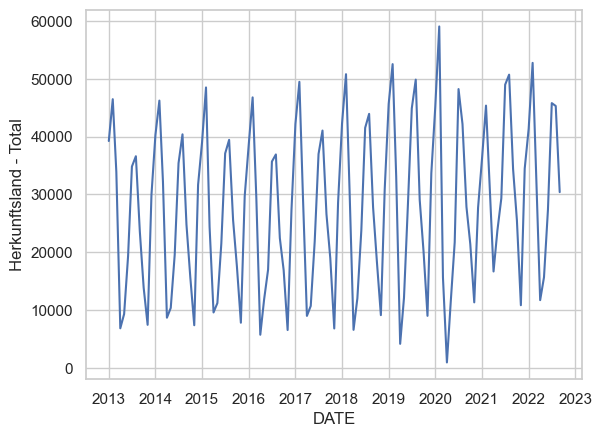

The series is NOT stationary


In [5]:
#preparing our df and defining exogenous variables as well as our endogenous variable
#creating array with n observations of variables and k number of variables and then filling it
exog = df.drop(columns=listen).to_numpy()
exo = df.drop(columns=listen)
endo = df["Herkunftsland - Total"]

#Plotting endo to check if it's static, which it seems...
sns.lineplot(endo)
plt.show()

#but to be really sure we can check it's stationarity with an augmented dickey-fuller-test
ph.check_stationarity(endo)

In [6]:
exog

array([[9.67690e+04, 7.33140e+04, 1.41988e+05, ..., 6.68000e+01,
        9.00000e+00, 2.00000e+00],
       [9.25430e+04, 8.72840e+04, 1.55304e+05, ..., 1.05300e+02,
        1.10000e+01, 3.00000e+00],
       [9.17160e+04, 7.73210e+04, 1.77233e+05, ..., 6.92000e+01,
        1.30000e+01, 3.00000e+00],
       ...,
       [1.01131e+05, 3.69620e+04, 1.54503e+05, ..., 4.76000e+01,
        6.00000e+00, 1.00000e+00],
       [1.07316e+05, 4.13350e+04, 1.46419e+05, ..., 9.25000e+01,
        7.00000e+00, 4.00000e+00],
       [5.47570e+04, 1.76640e+04, 1.14863e+05, ..., 1.53500e+02,
        1.60000e+01, 3.00000e+00]])

# Freude herrscht! Apparently it's not - as if it wasn't hard enough already
*at least we now know that d is not equal to 0 - but i'll get to that later*

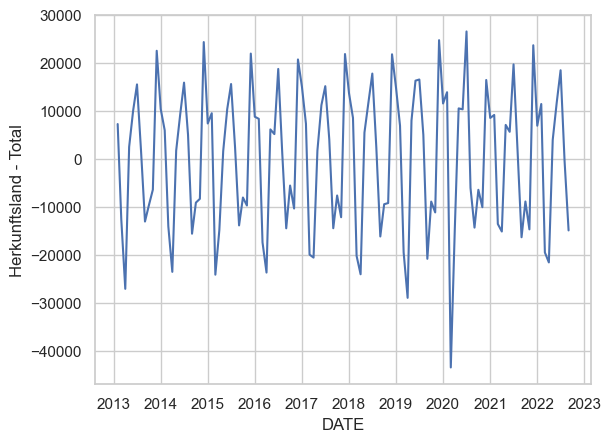

The series is stationary


In [7]:
#let's try to make endo stationary by removing the trend:
# we try to do this by taking the difference of between the current value and the prior month's value
endo_diff = endo.diff()[1:] 
exog_diff = np.diff(exog)[1:] 
# let's check
sns.lineplot(endo_diff)
plt.show()
#and also Dickey-Fuller agrees with us:
ph.check_stationarity(endo_diff)

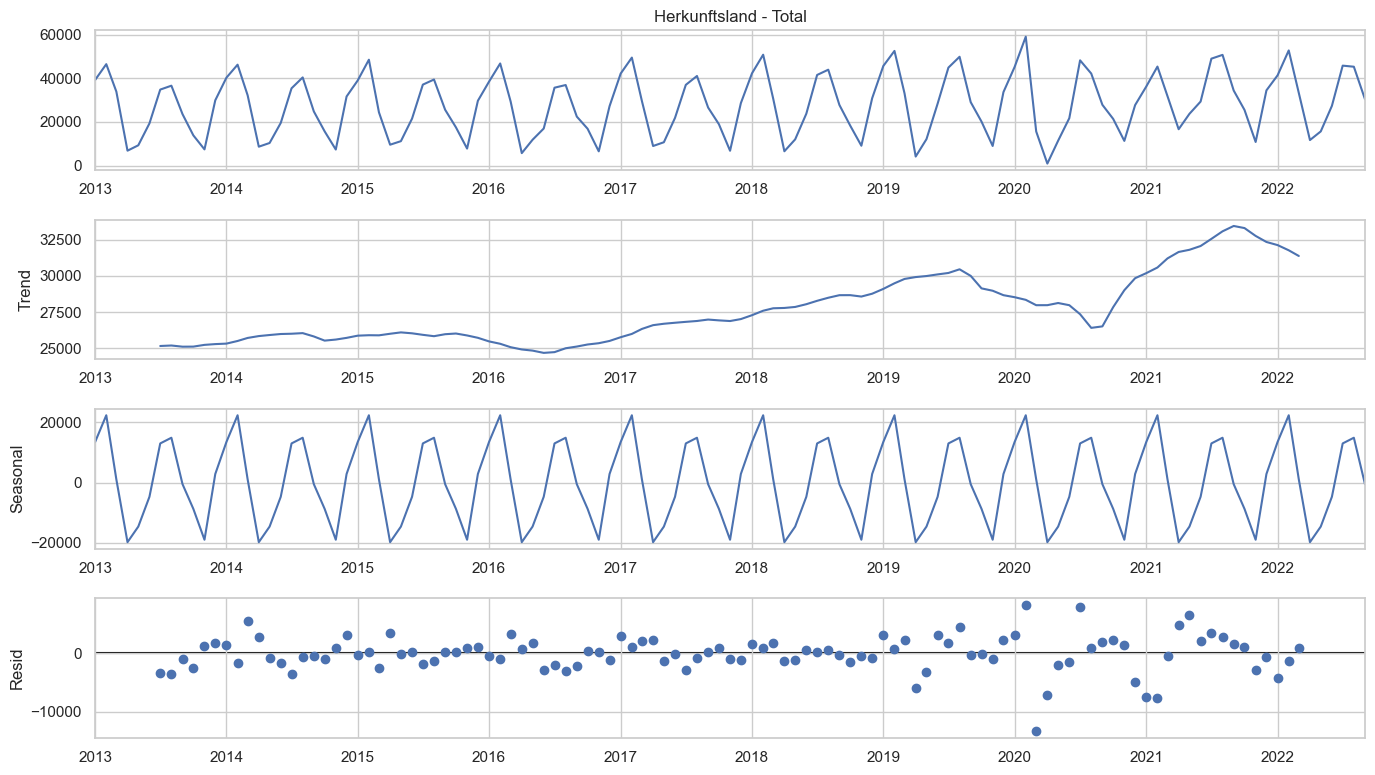

In [8]:
#now we are using STL decomposition for our DF
#Decomposing DF into Trend, Seasonality and Residue so we can fit it into our seasonal ARIMA(X)
from statsmodels.tsa.seasonal import seasonal_decompose

df_seasonal = seasonal_decompose(endo, model='additive')

#It's important to see a strong seasonal influence - otherwise we use ARIMA(X)
plt.rc('figure',figsize=(14,8))
plt.rc('font',size=15)
df_seasonal.plot();
plt.show()

### Here we can clearly see that there is some kind of trend (*and a remarkable one to say the least*) in our df
#### we also notice the big seasonal differences

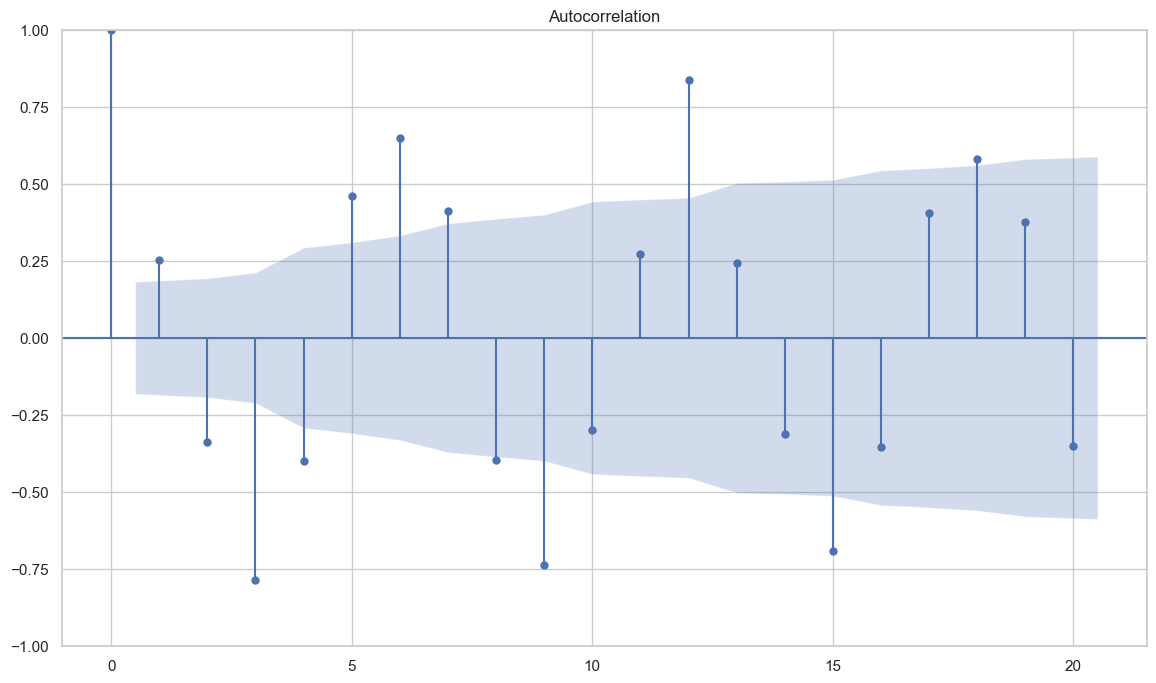

In [9]:
# Trying to evaluate the ideal values of p and q using partial autocorrelation / autocorrelation functions
# See --> https://otexts.com/fpp2/non-seasonal-arima.html#acf-and-pacf-plots
plot_acf(endo_diff, lags=20);
plt.show()


## **The biggest spike is at the 12 months mark, thus implies we should continue our work with a p value of 12**

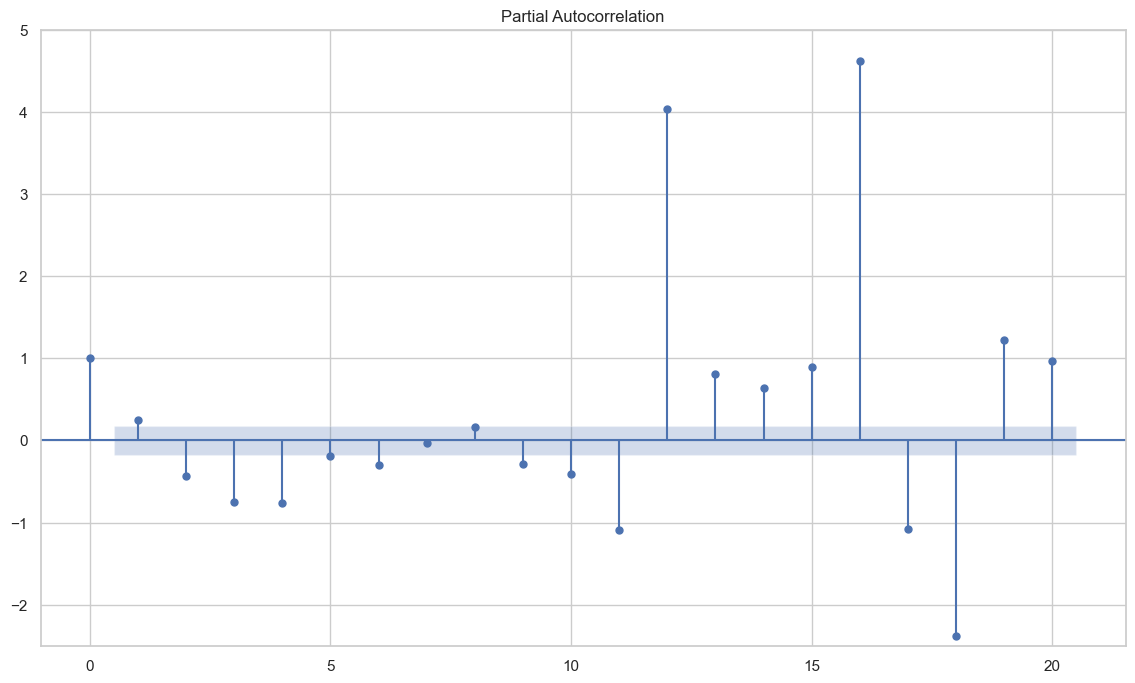

In [10]:
plot_pacf(endo_diff, lags=20);
plt.ylim(-2.5,5)
plt.show()

### There are **VERY** significant spikes at12 in our AFC and PAFC plot. - the huge spike at the 16 month could be covid -idk tho

# Let's get training and testing sets now. so we can make sure our model works correctly

In [11]:
#Cross Validation by using sklearns TSSplit
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=6)
#split our TS in test and train sets
for train_index, test_index in tss.split(exog):
    exog_train, exog_test = exog[train_index, :], exog[test_index,:]
    endo_train, endo_test = endo.iloc[train_index], endo.iloc[test_index]
    exo_train, exo_test = exo.iloc[train_index], exo.iloc[test_index]

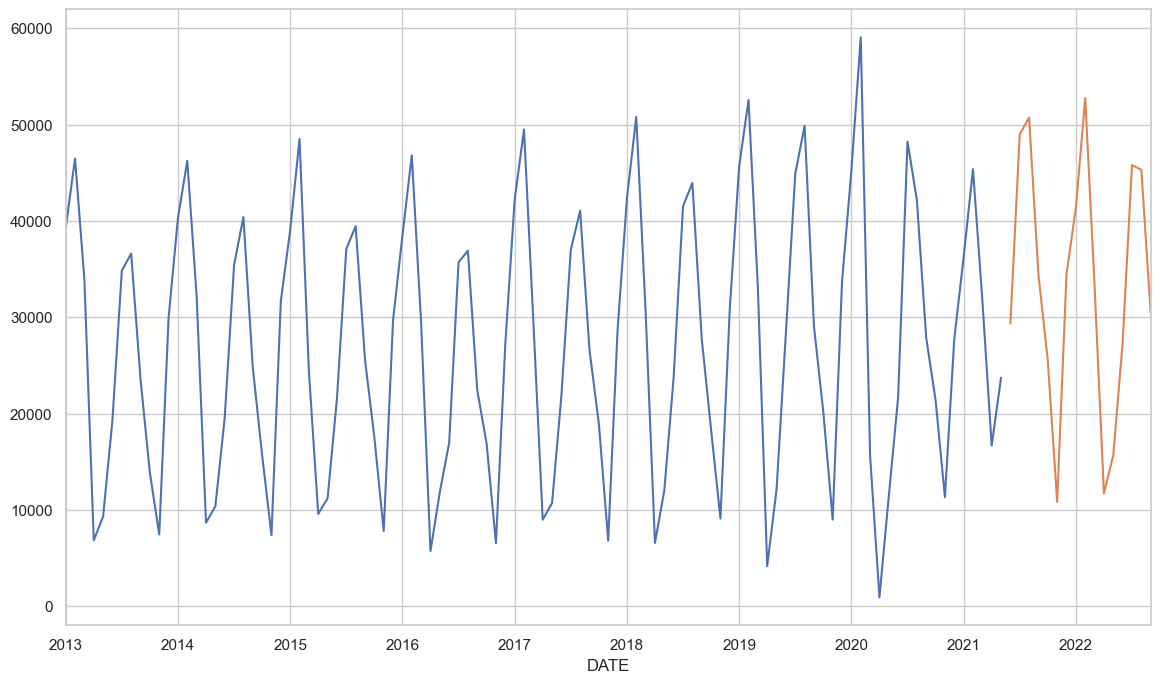

In [12]:
#showing train and test set in one plot to get an understanding of the split
endo_train.groupby('DATE').mean().plot()
endo_test.groupby('DATE').mean().plot()

plt.show()

In [13]:
#let's now define our training endos and exos with a d=1 and p=12 // order = pdq is 0,1,0 bc the date is very heavily influenced by seasonality however we were able to appply diff1 to it to integrate it
smodel = SARIMAX(endog=endo_train,exog=exo_train, order=(1,0,0), seasonal_order=(0,0,2,12))

In [14]:
#Let's fit the model now:
start = time()
fit_smodel = smodel.fit()
end = time()
print("The model took ", end - start,"seconds to be fitted")

#OUTPUT:

# RUNNING THE L-BFGS-B CODE

#            * * *

# Machine precision = 2.220D-16
#  N =          167     M =           10

# At X0         0 variables are exactly at the bounds

# At iterate    0    f= -1.03835D+01    |proj g|=  1.05141D+14
#  This problem is unconstrained.

#  Line search cannot locate an adequate point after MAXLS
#   function and gradient evaluations.
#   Previous x, f and g restored.
#  Possible causes: 1 error in function or gradient evaluation;
#                   2 rounding error dominate computation.

#            * * *

# Tit   = total number of iterations
# Tnf   = total number of function evaluations
# Tnint = total number of segments explored during Cauchy searches
# Skip  = number of BFGS updates skipped
# Nact  = number of active bounds at final generalized Cauchy point
# Projg = norm of the final projected gradient
# F     = final function value

#            * * *

#    N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
#   167      1     21      1     0     0   1.051D+14  -1.038D+01
#   F =  -10.383511680414193     

# ABNORMAL_TERMINATION_IN_LNSRCH                              
# The model took  11.60127305984497 seconds to be fitted

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          168     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.05939D+01    |proj g|=  8.44052D+14



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  168      1     21      1     0     0   8.441D+14  -1.059D+01
  F =  -10.593908814534494     

ABNORMAL_TERMINATION_IN_LNSRCH                              
The model took  8.630644798278809 seconds to be fitted


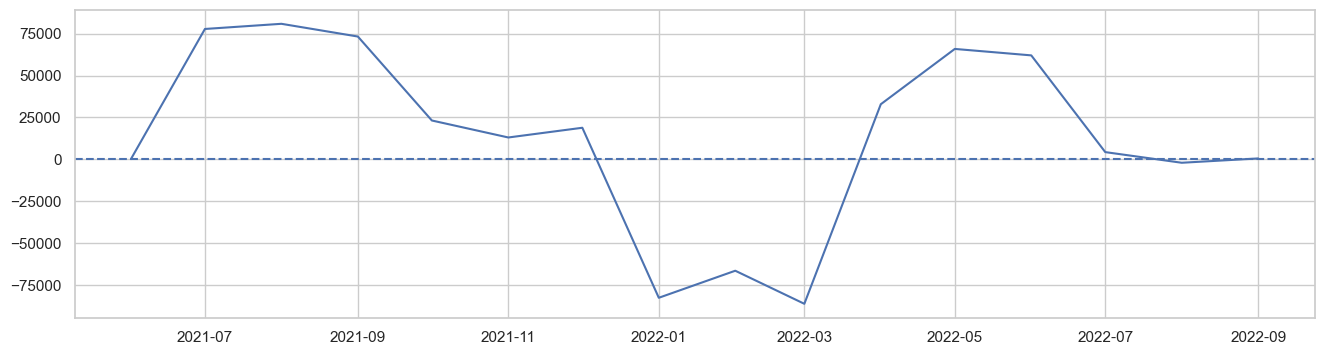

our MAE is 43127.76728284366


In [15]:
forecast = fit_smodel.forecast(len(endo_test), exog=exo_test)
forecast = pd.Series(forecast, index=endo_test.index)
residue = endo_test - forecast

plt.figure(figsize=(16,4))
plt.plot(residue, label="Residual")
plt.axhline(0, linestyle="--")
plt.show()

print("our MAE is", np.mean(np.abs(endo_test - forecast)))

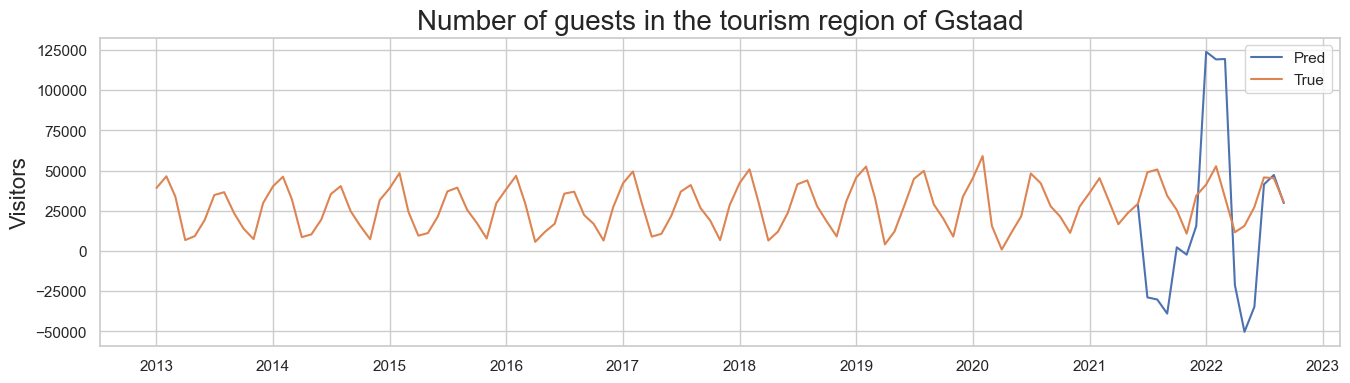

In [16]:
#now we can plot our predictions to see whether we were doing alright
plt.figure(figsize=(16,4))
plt.plot(forecast, label="Pred")
plt.plot(endo, label="True")
#plt.plot(predictions4, label="Predicted3")
plt.title("Number of guests in the tourism region of Gstaad", fontsize=20)
plt.ylabel('Visitors', fontsize=16) 
plt.ylim()
plt.legend()
plt.show()

,guests-St. Moritz,guests-Arosa,guests-Zermatt,AUS_GDP,AUT_GDP,BEL_GDP,BGR_GDP,CAN_GDP,CHE_GDP,CHL_GDP,...,cm neuschnee - gsg,cm avg. snowheight - gsg,mm rain - gsg,days rain >1mm - gsg,days rain >10mm - gsg,cm neuschnee - zwe,cm avg. snowheight - zwe,mm rain - zwe,days rain >1mm - zwe,days rain >10mm - zwe
DATE,,,,,,,,,,,,,,,,,,,,,
2021-06-01,21045.0,13880.0,41287.0,58335.70,58146.4,57602.00,27490.00,51043.1,75129.80,27605.0,...,0,0,164.4,14,10,0,0,185.9,17,8
2021-07-01,93707.0,48299.0,116789.0,58205.80,60820.4,59315.20,28356.80,52562.5,77419.70,29152.1,...,0,0,294.1,17,10,0,0,228.6,17,9
2021-08-01,104345.0,46770.0,148836.0,58205.80,60820.4,59315.20,28356.80,52562.5,77419.70,29152.1,...,0,0,121.5,9,6,0,0,98.7,9,5
2021-09-01,50202.0,24628.0,96501.0,58205.80,60820.4,59315.20,28356.80,52562.5,77419.70,29152.1,...,0,0,100.0,13,2,0,0,70.5,9,2
2021-10-01,31707.0,14323.0,65258.0,61403.30,60754.9,60317.90,28877.60,54212.9,78757.80,29969.2,...,0,0,43.5,8,1,0,0,22.2,5,0
2021-11-01,12080.0,4214.0,37551.0,61403.30,60754.9,60317.90,28877.60,54212.9,78757.80,29969.2,...,32,2,50.1,9,1,0,0,30.6,8,1
2021-12-01,87437.0,49743.0,137449.0,61403.30,60754.9,60317.90,28877.60,54212.9,78757.80,29969.2,...,122,46,183.5,14,6,0,0,144.7,14,5
2022-01-01,87990.0,56003.0,150217.0,63093.90,62494.4,61588.20,28903.80,55670.4,80513.10,30265.9,...,68,46,56.5,6,3,0,0,35.3,5,1
2022-02-01,108832.0,79859.0,172334.0,63093.90,62494.4,61588.20,28903.80,55670.4,80513.10,30265.9,...,68,67,156.4,15,5,0,0,83.6,12,3


In [17]:
train_end = datetime(2021,5,1)
test_end = datetime(2022,9,1)
startparams = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,1,1]

traintrain_exo = exo[train_end:]

rolling_predictions = endo_test.copy()
for train_end in endo_test.index:
    train_data = endo[:train_end-timedelta(days=1)]
    train_exo = exo[:train_end-timedelta(days=1)]
    model = SARIMAX(train_data, order=(1,2,0), seasonal_order=(0,2,1,12),exog=train_exo, )
    model_fit = model.fit(start_params=None)
    
    pred = model_fit.forecast(exog=traintrain_exo.loc[[train_end-timedelta()]])
    rolling_predictions[train_end] = pred


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          167     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  6.48211D+04


 This problem is unconstrained.


  ys=-5.754E-16  -gs= 1.618E-08 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  167      5     95      2     1     0   7.581D+07  -2.582D+00
  F =  -2.5821077339734222     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          167     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  9.41408D+04


 This problem is unconstrained.


  ys=-2.315E-14  -gs= 3.779E-07 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  167      4     84      2     1     0   3.158D+07  -2.480D+00
  F =  -2.4804330084956621     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          167     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  7.18214D+03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  167      3     62      2     0     0   8.883D+05  -9.554D-01
  F = -0.95540542590926225     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          167     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  167      0      1      0     0     0   0.000D+00  -0.000D+00
  F =  -0.0000000000000000     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          167     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  2.46822D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  167      3     42      1     0     0   7.933D+06  -1.789D+00
  F =  -1.7886942447874481     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          167     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.95117D-02    |proj g|=  7.72024D+11


 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  167      1     21      1     0     0   7.720D+11  -4.951D-02
  F =  -4.9511688822924768E-002

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          167     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  3.37636D+04


 This problem is unconstrained.


  ys=-3.174E-13  -gs= 1.211E-06 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  167      5     92      2     1     0   8.546D+06  -1.800D+00
  F =  -1.8003001632434619     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          167     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  2.42863D+04


 This problem is unconstrained.


  ys=-9.189E-13  -gs= 3.571E-06 BFGS update SKIPPED

At iterate    5    f= -1.78113D+00    |proj g|=  4.72433D+06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  167      5     70      1     1     0   4.724D+06  -1.781D+00
  F =  -1.7811295231980810     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          167     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  9.46735D+03


 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  167      3     62      2     0     0   7.891D+06  -1.810D+00
  F =  -1.8097575139797064     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          167     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.81068D-02    |proj g|=  1.46547D+11


 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  167      1     21      1     0     0   1.465D+11  -4.811D-02
  F =  -4.8106763469583758E-002

ABNORMAL_TERMINATION_IN_LNSRCH                              


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          167     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  5.16091D+04
  ys=-1.775E-11  -gs= 2.818E-05 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  167      3     63      2     1     0   6.843D+07  -2.661D+00
  F =  -2.6611127798582226     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          167     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  2.34202D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  167      2     24      1     0     0   4.763D+06  -1.794D+00
  F =  -1.7939508937144406     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          167     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  7.51990D+05


 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  167      2     47      2     0     0   3.252D+08  -3.470D+00
  F =  -3.4702154913955057     

ABNORMAL_TERMINATION_IN_LNSRCH                              


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          167     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  5.02705D+03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  167      2     44      2     0     0   9.797D+05  -9.873D-01
  F = -0.98725281848807256     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          167     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  3.28421D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  167      4     54      1     0     0   5.893D+06  -1.827D+00
  F =  -1.8265772631188091     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          167     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.18525D-01    |proj g|=  2.66549D+11


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  167      1     21      1     0     0   2.665D+11  -2.185D-01
  F = -0.21852493842438886     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


In [18]:
rolling_residuals = endo_test - rolling_predictions

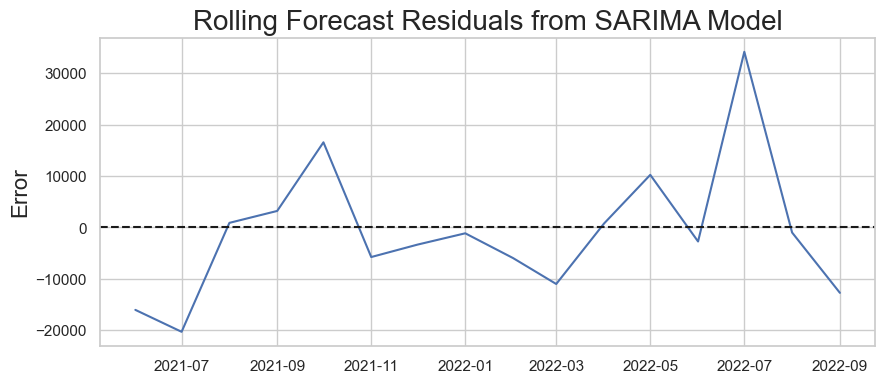

In [19]:
plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.show()

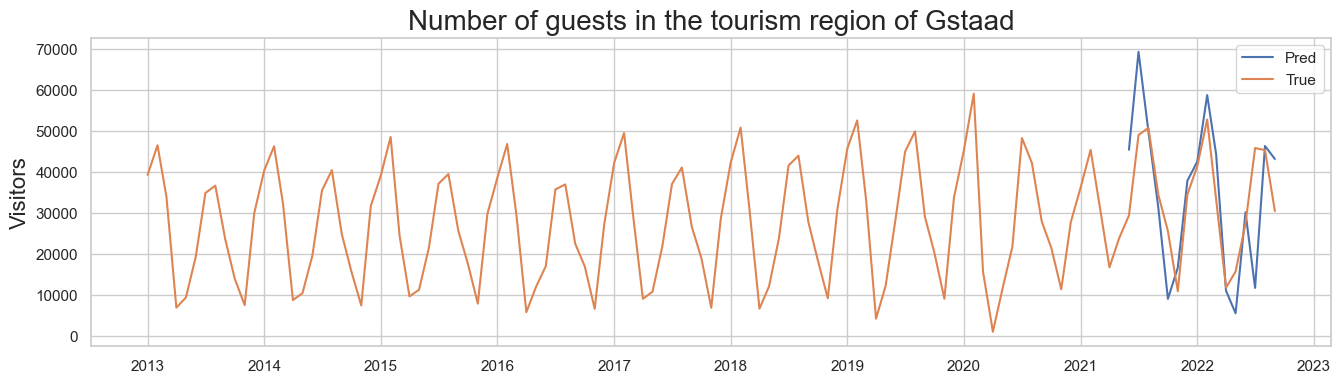

In [20]:
plt.figure(figsize=(16,4))
plt.plot(rolling_predictions, label="Pred")
plt.plot(endo, label="True")
#plt.plot(predictions4, label="Predicted3")
plt.title("Number of guests in the tourism region of Gstaad", fontsize=20)
plt.ylabel('Visitors', fontsize=16) 
plt.ylim()
plt.legend()
plt.show()

In [22]:
#you can add your calcs here @elia

# Ignore everything underneath

In [229]:
print(model_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                Herkunftsland - Total   No. Observations:                  116
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 12)   Log Likelihood                1207.673
Date:                              Sat, 03 Dec 2022   AIC                          -2081.347
Time:                                      17:33:31   BIC                          -1622.943
Sample:                                  01-01-2013   HQIC                         -1895.283
                                       - 08-01-2022                                         
Covariance Type:                                opg                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
guests-St. Moritz           -0.2738   9.83e-07  -2.79e+05      0.000  

### I do not like what I see... looks like overfitting

In [43]:
# Construct the model
mod = sm.tsa.SARIMAX(endog=endo,exog=exog, order=(1, 1, 1), seasonal_order=(1,1,0,9))
# Estimate the parameters
res = mod.fit()

print(res.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          168     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.84786D-01    |proj g|=  8.75817D+15


 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  168      1     21      1     0     0   8.758D+15  -9.848D-01
  F = -0.98478586806706137     

ABNORMAL_TERMINATION_IN_LNSRCH                              
                                     SARIMAX Results                                      
Dep. Variable:              Herkunftsland - Total   No. Observations:                  117
Model:             SARIMAX(1, 1, 1)x(1, 1, [], 9)   Log Likelihood                 115.220
Date:                            Sat, 03 Dec 2022   AIC                            105.560
Time:                                    11:34:46   BIC    

In [64]:
#trying to forecast the month of October using exog Data of september
print(res.forecast(exog=exog[116]))
print(res.predict(exog=exog[116]))


#let's try to forecast two months now
fcast_res1 = res.get_forecast(exog=exog[114:116], steps=2)
fcast_res2 = res.get_prediction(exog=exog[114:116], steps=2)
# Here we specify that we want a confidence level of 90% by setting alpha
print(fcast_res1.summary_frame(alpha=0.1))
print(fcast_res2.summary_frame(alpha=0.1))

2022-10-01    42530.897203
Freq: MS, dtype: float64
2013-01-01   -1.209034e+06
2013-02-01    3.582370e+04
2013-03-01    3.024808e+04
2013-04-01   -3.402757e+02
2013-05-01    1.720788e+04
                  ...     
2022-05-01    1.566800e+04
2022-06-01    2.736500e+04
2022-07-01    4.579400e+04
2022-08-01    4.529900e+04
2022-09-01    3.039700e+04
Freq: MS, Name: predicted_mean, Length: 117, dtype: float64
Herkunftsland - Total          mean  mean_se  mean_ci_lower  mean_ci_upper
2022-10-01             45762.917713      NaN            NaN            NaN
2022-11-01             67666.019826      NaN            NaN            NaN
Herkunftsland - Total          mean      mean_se  mean_ci_lower  mean_ci_upper
2013-01-01            -1.209034e+06  1414.213562  -1.211360e+06  -1.206708e+06
2013-02-01             3.582370e+04  1000.000000   3.417885e+04   3.746856e+04
2013-03-01             3.024808e+04  1000.000000   2.860323e+04   3.189294e+04
2013-04-01            -3.402757e+02  1000.000000  

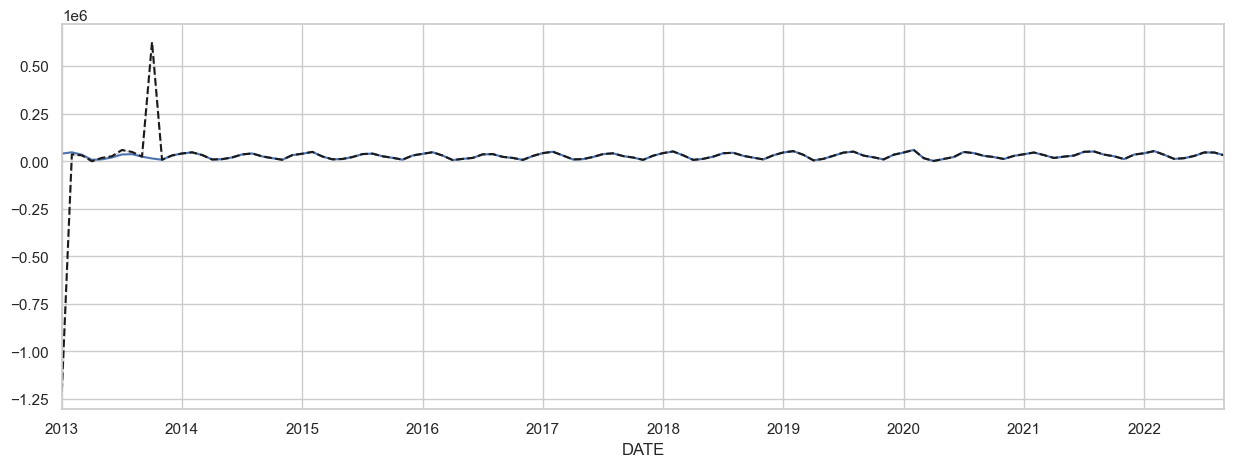

In [63]:
fig, ax = plt.subplots(figsize=(15, 5))

# Plot the data (here we are subsetting it to get a better look at the forecasts)
endo.loc['1999':].plot(ax=ax)

# Construct the forecasts
fcast = res.get_prediction(exog=exog[114:116], steps=2).summary_frame()
fcast['mean'].plot(ax=ax, style='k--')
ax.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.1);

In [35]:
#other approach with cv
def SARIMA_CV(df, target, order, seasonal_order):
    
    y = df[target]
    errors = [] 
    for month in [7, 8, 9]:
        start = datetime(year, 1, 1)
        end = start + (1)

        # split data
        y_tr = y.loc[:start-timedelta(1)]
        y_val = y.loc[start:end]
                
        # train Seasonal ARIMA Model
        model = SARIMAX(y_tr, order=order, seasonal_order=seasonal_order)
        fit = model.fit()

        # forecast
        y_pred = fit.forecast(len(y_val))

        # error
        err = RMSLE(y_val, y_pred)
        errors.append(err)

        print(f'\n Validation on Month {month}:')
        print(f'\t Number of Train Data: {len(y_tr)}')
        print(f'\t Number of Validation Data: {len(y_val)}')
        print(f'\t RMSLE: {err}')

        fig, ax = plt.subplots(figsize=(16,3))
        months = mdates.MonthLocator()
        for name, dat, c in zip(['train', 'valid', 'pred'], [y_tr, y_val, y_pred], ['b', 'g', 'r']):
            ax.plot(dat, c=c, label=name)
        ax.xaxis.set_major_locator(months)
        plt.legend()
        plt.grid()
        plt.show()
    
    print(f'\n Mean RMSLE: {np.mean(errors)}')
    print(f' Std RMSLE: {np.std(errors)}')

    
# root mean square logarithmic error
def RMSLE(y_true, y_pred):
    MSLE = mean_squared_log_error(y_true, y_pred)
    return np.sqrt(MSLE)

In [36]:
SARIMA_CV(df,"Herkunftsland - Total",(1,1,1),(1,1,0,9))

NameError: name 'MonthEnd' is not defined

In [7]:
#Importing product manually from itertools bc itertools.prduct does not work in my code
from itertools import product

#Assigning a value between 0 and 2 to our autoregressive terms(AR), Variable used to make data stationary(I), moving average(MA) 
p = d = q = range(0, 2)

#working out all possible combinations of p,d and q
pdq = list(product(p, d, q))

#doing the same for our seasonal pdq values:
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(product(p, d, q))]

#Showing examples for our pdq and spdq combs
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [103]:
#magically finding the optimal combination of pdq and spdq for our model
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(endog=train.Rides,\
                                            trend='n',\
                                            order=(1,0,1),\
                                            seasonal_order=(1,0,1,12))

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

NameError: name 'results' is not defined

# ××× ⬇Don't look at the code below, it's outdated and unnecessary⬇ ×××

In [70]:
X = w.drop(columns=listen)
y = w["Herkunftsland - Total"]

In [62]:
#interpret the correlations in the dataframe
df.corr()

,Argentina,Australien,Austria,Bahrain,Belarus,Belgium,Brasil,Bulgaria,Canada,China,...,cm avg. snowheight - gsg,mm rain - gsg,days rain >1mm - gsg,days rain >10mm - gsg,cm neuschnee - zwe,cm avg. snowheight - zwe,mm rain - zwe,days rain >1mm - zwe,days rain >10mm - zwe,season
Argentina,1.000000,0.438428,0.455130,0.276178,0.285083,0.357407,0.352341,0.182852,0.441103,0.631199,...,-0.013449,0.092898,0.072565,0.145398,0.016888,0.020205,0.139620,0.084860,0.150896,-0.022228
Australien,0.438428,1.000000,0.504140,0.251377,0.160082,0.416508,0.632224,0.352375,0.701872,0.379020,...,0.127336,-0.002239,-0.006547,0.034788,0.044340,0.011207,0.069651,0.004224,0.050034,-0.270078
Austria,0.455130,0.504140,1.000000,0.206434,0.077852,0.343236,0.488048,0.244677,0.575960,0.508148,...,-0.029605,0.162913,0.108083,0.192633,0.105960,0.173041,0.234190,0.157184,0.235598,-0.112944
Bahrain,0.276178,0.251377,0.206434,1.000000,0.084727,0.154594,0.216866,0.042597,0.181808,0.133414,...,-0.052356,-0.085012,-0.127256,-0.023721,0.073597,-0.015720,-0.070815,-0.110085,-0.024627,-0.174846
Belarus,0.285083,0.160082,0.077852,0.084727,1.000000,0.046190,0.037225,-0.006040,0.054964,0.120891,...,-0.028249,-0.023871,0.029471,-0.043125,0.264760,0.112976,0.029195,0.037667,-0.014771,-0.122342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cm avg. snowheight - zwe,0.020205,0.011207,0.173041,-0.015720,0.112976,0.470394,0.235841,0.396793,0.054461,-0.033741,...,0.224928,-0.069240,-0.059303,-0.101734,0.842106,1.000000,-0.072824,-0.030736,-0.086230,-0.286441
mm rain - zwe,0.139620,0.069651,0.234190,-0.070815,0.029195,-0.012187,0.016694,0.003105,0.080657,0.083627,...,-0.144967,0.898602,0.752165,0.836350,-0.038074,-0.072824,1.000000,0.819128,0.921069,-0.021719
days rain >1mm - zwe,0.084860,0.004224,0.157184,-0.110085,0.037667,0.011553,-0.032456,0.020938,-0.002970,-0.005272,...,-0.052989,0.802124,0.910774,0.766966,0.022023,-0.030736,0.819128,1.000000,0.728979,-0.084061
days rain >10mm - zwe,0.150896,0.050034,0.235598,-0.024627,-0.014771,-0.022458,0.016428,0.017884,0.049475,0.115139,...,-0.145045,0.806827,0.648925,0.792771,-0.058214,-0.086230,0.921069,0.728979,1.000000,-0.009968


In [80]:
X_train,X_test,y_train,y_test = train_test_split(X,y)

(8,)

In [81]:
# 2 degrees of polynomials, without the constant
poly2 = PolynomialFeatures(2, include_bias=False) 
# Define a new X with the squared feature
X2 = poly2.fit_transform(X_train)
X2[:5, :] # Check the first five rows of our new features
ols2 = LinearRegression()

In [84]:
ols1.fit(X2, y_train)
crops = ols1.predict(X2)

# Get value of constant and coefficient
print(f"constant: {ols1.intercept_:.2f}, coefficient: {ols1.coef_[0]:.7f}.")

constant: 10149.45, coefficient: 0.0000001.


1.0

constant: -465340.78, coefficient: 0.2901861.


0.28511501427106667

10022.643199796497

In [7]:
# 2 degrees of polynomials, without the constant
poly2 = PolynomialFeatures(2, include_bias=False) 
# Define a new X with the squared feature
X2 = poly2.fit_transform(X_train)
X2[:5, :] # Check the first five rows of our new features
ols2 = LinearRegression()

In [167]:
# Fit the estimator 
ols2.fit(X2, y_train)
# Add the predictions to our `crops` dataframe
X2_test = poly2.fit_transform(X_test)
cropsy = ols2.predict(X2_test)


In [56]:
df2['Date'] = pd.to_datetime(df2.DATE, format='%Y-%m-%d')



In [71]:
df2['season'] = (df2['Date'].dt.month%12 + 3)//3

seasons = {
             1: 'Winter',
             2: 'Spring',
             3: 'Summer',
             4: 'Autumn'
}

df2['season_name'] = df2['season'].map(seasons)

KeyError: 'Date'

In [59]:
w = df2[df2["season"] == 1].reset_index().drop(columns=["index","DATE","Date","season","season_name"])
f = df2[df2["season"] == 2].reset_index().drop(columns="index")
s = df2[df2["season"] == 3].reset_index().drop(columns="index")
h = df2[df2["season"] == 4].reset_index().drop(columns="index")

In [72]:
def split_seasons(df):
    df['Date'] = pd.to_datetime(df.DATE, format='%Y-%m-%d')
    df['season'] = (df['Date'].dt.month%12 + 3)//3
    df['season_name'] = df['season'].map(seasons)

    w = df[df["season"] == 1].reset_index().drop(columns=["index","DATE","Date","season","season_name"])
    f = df[df["season"] == 2].reset_index().drop(columns=["index","DATE","Date","season","season_name"])
    s = df[df["season"] == 3].reset_index().drop(columns=["index","DATE","Date","season","season_name"])
    h = df[df["season"] == 4].reset_index().drop(columns=["index","DATE","Date","season","season_name"])
    return(w,f,s,h)

In [73]:
w,f,s,h = split_seasons(df2)

In [74]:
w

,Argentina,Australien,Austria,Bahrain,Belarus,Belgium,Brasil,Bulgaria,Canada,China,...,cm neuschnee - gsg,cm avg. snowheight - gsg,mm rain - gsg,days rain >1mm - gsg,days rain >10mm - gsg,cm neuschnee - zwe,cm avg. snowheight - zwe,mm rain - zwe,days rain >1mm - zwe,days rain >10mm - zwe
0,8.0,218.0,98.0,10.0,32.0,721.0,331.0,9.0,159.0,29.0,...,76,57,97.1,13,4,33,5,66.8,9,2
1,12.0,13.0,180.0,21.0,2.0,2023.0,323.0,176.0,82.0,84.0,...,120,86,138.0,13,2,119,27,105.3,11,3
2,0.0,68.0,125.0,0.0,0.0,361.0,69.0,25.0,77.0,241.0,...,0,19,59.7,7,2,17,7,42.1,4,1
3,53.0,267.0,191.0,6.0,630.0,658.0,394.0,54.0,120.0,65.0,...,0,40,87.5,9,5,47,9,83.6,11,3
4,62.0,80.0,183.0,2.0,0.0,846.0,235.0,242.0,66.0,220.0,...,0,80,152.7,18,6,48,13,105.2,11,6
5,6.0,42.0,82.0,132.0,593.0,449.0,107.0,34.0,52.0,168.0,...,64,6,94.1,12,3,56,4,76.4,8,2
6,95.0,170.0,102.0,8.0,447.0,685.0,180.0,17.0,97.0,63.0,...,0,22,162.0,17,8,81,12,119.8,18,4
7,36.0,46.0,202.0,0.0,0.0,1739.0,337.0,104.0,127.0,91.0,...,0,0,66.0,6,3,50,33,48.3,7,1
8,0.0,70.0,126.0,0.0,0.0,374.0,45.0,19.0,80.0,157.0,...,0,16,18.8,6,0,0,1,15.8,5,0
9,23.0,146.0,48.0,10.0,40.0,637.0,146.0,56.0,70.0,102.0,...,122,47,257.1,21,8,0,0,139.6,17,5


In [78]:
y2 = w["Herkunftsland - Total"]
#X = df.drop(["Herkunftsland - Total"], axis=1)
X2 = w.drop(columns=listen)

In [81]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.20)

In [85]:
# 2 degrees of polynomials, without the constant
poly2 = PolynomialFeatures(2, include_bias=False) 
# Define a new X with the squared feature
X3 = poly2.fit_transform(X2_train)
X3[:5, :] # Check the first five rows of our new features
ols2 = LinearRegression()

In [86]:
# Fit the estimator 
ols2.fit(X3, y2_train)
# Add the predictions to our `crops` dataframe
X2_test = poly2.fit_transform(X2_test)
cropsy = ols2.predict(X2_test)


In [88]:
mae3 = np.mean(np.abs(cropsy - y2_test))
mae3 # Display the MAE

2828.821778881878

In [96]:
prediction = pd.DataFrame(y2_test).reset_index()
prediction["pred"] = cropsy

In [97]:
prediction

,index,Herkunftsland - Total,pred
0,13,49478.0,49442.172684
1,11,27217.0,31252.191250
2,0,39240.0,39672.814652
3,22,59058.0,49985.712725
4,7,48506.0,47044.627753
5,1,46474.0,48409.437933


In [94]:
y2_test

13    49478.0
11    27217.0
0     39240.0
22    59058.0
7     48506.0
1     46474.0
Name: Herkunftsland - Total, dtype: float64